# Estimating the NAs in the dataset

Our coral dataset has 620 rows and 39 columns. We found 113 missing values in one of our predictor variables, and due to the small dataset size, we work to predict those values here. 

We use two methods to estimate - lasso regression and k-means clustering - and compare both to using the mean. 

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline

### Read in the data

In [236]:
# read in the data
df = pd.read_csv("../Data/Hawaii_RegimesPredictors.txt", sep="\t", decimal=",")

In [237]:
print(df.shape)
df.head()

(620, 39)


,id_spatial,Long,Lat,Island,Coral,CCA,Turf,Macro,Other,Grazers,...,PAR_STD,WAV_CLIM_M,WAV_ANOM_F,Complexity,Depth,Regime,Regime1,Regime2,Regime3,Regime5
0,4,-157.307727,21.106717,Molokai,1.023891,1.706485,77.815700,18.088737,1.023891,1.324986,...,8.5628,36.542160,0.083878,4.889608,2.8000,1,1,0,0,0
1,5,-157.304986,21.113497,Molokai,3.555556,1.333333,83.555556,9.777778,0.888889,0.890407,...,8.5628,36.542160,0.083878,3.793523,7.3152,1,1,0,0,0
2,6,-157.303306,21.124814,Molokai,17.620555,6.348836,44.875760,25.716525,4.836712,4.628477,...,9.4296,38.007866,0.084089,5.275938,11.5000,2,0,1,0,0
3,8,-157.299938,21.148297,Molokai,0.675676,1.351351,86.486487,0.337838,5.743243,0.069128,...,9.4296,39.139775,0.087039,2.511288,29.1000,1,1,0,0,0
4,9,-157.300286,21.128897,Molokai,4.000000,3.111111,53.333333,17.333333,21.777778,11.775000,...,9.4296,40.587803,0.084932,6.865359,10.0584,2,0,1,0,0


## Data prep

In [238]:
def data_prep(df):
    df = df.astype({"id_spatial": "category", "Island": "category", "Habitat_Modification": "category", 
               "Invasive_Algae": "category", "Regime": "category", "Regime1": "category", 
               "Regime2": "category", "Regime3": "category", "Regime5": "category"})
    return df

In [239]:
random.seed(47)
df = data_prep(df)

# Explore the data set

#### Which columns have NA's?

In [240]:
na_cols = df.apply(lambda x : x.isna().sum())
na_cols[na_cols>0]

Complexity    113
Depth          12
dtype: int64

### Depth

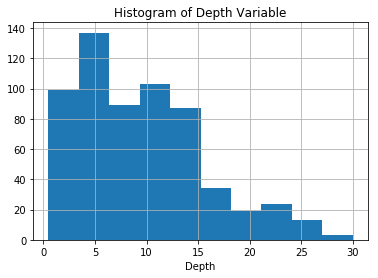

In [241]:
plt.hist(df.Depth[df.Depth.notna()])
plt.title("Histogram of Depth Variable")
plt.xlabel("Depth")
plt.grid()

We'll just replace the 12 missing values of Depth with the median value of Depth

In [242]:
df.loc[df.Depth.isna(), 'Depth'] = df.Depth[df.Depth.notna()].median()

In [243]:
# Check if the NAs are gone:
na_cols = df.apply(lambda x : x.isna().sum())
na_cols[na_cols>0]

Complexity    113
dtype: int64

## Estimate the missing complexity values

#### Plot distribution of complexity variable

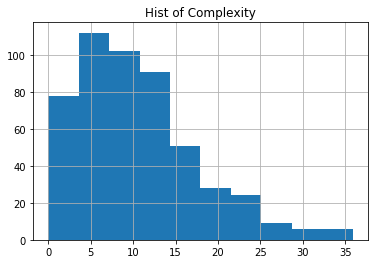

In [244]:
plt.hist(df.Complexity[df.Complexity.notna()])
plt.title("Hist of Complexity")
plt.grid()
plt.show()

#### Data prep

In [245]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale

# Create dataset of only rows that are not NA. 
df_complex = df[df.Complexity.notna()]
print("df_complex.shape", df_complex.shape)

# correlations
#print (df[cols].corrwith(pd.Series(v, index=df.columns), axis=1))

response = df_complex['Complexity']
predictors = df_complex.columns[:-7]
predictors = predictors[1:]
df_complex = df_complex[predictors]
# print(df_complex.columns)

# change Island variable to numeric encoding. 
lb = LabelEncoder()
island_dummy = lb.fit_transform(df_complex.Island)
island_dummy
lb.inverse_transform(island_dummy)
df_complex.Island = island_dummy 

# Scale data 
df_complex_means = np.mean(df_complex, axis=0)
df_complex_stds  = np.std(df_complex, axis=0)
df_complex_scaled = scale(df_complex.values)

# Split into train, validation
complex_train, complex_test, complex_train_y, complex_test_y = train_test_split(df_complex, response, test_size=0.15)

complex_train, complex_valid, complex_train_y, complex_valid_y = train_test_split(complex_train, complex_train_y, test_size=0.2)

assert(complex_train.shape[0] + complex_valid.shape[0] + complex_test.shape[0] == df_complex.shape[0])

df_complex.shape (507, 39)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


##### RMSE & lasso helper

In [246]:
def calc_rmse(predictions, true_values, n):
    return np.sqrt(1/n*sum((predictions - true_values)**2))

def run_lasso(train, train_response, valid, valid_response, lamb):
    lassoreg = Lasso(alpha = lamb, normalize=True, max_iter=1e5)
    lassoreg.fit(train, train_response)
    y_pred = lassoreg.predict(valid)
    rss = calc_rmse(y_pred, valid_response, valid.shape[0])
    return rss, y_pred, lassoreg

##### Run Lasso simulations

In [247]:
lambdas = [10, 1, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
RMSE = np.zeros(len(lambdas))
best_rmse_lasso = 100000 
best_lambda = 0
best_predictions = None
best_model = None
i = 0
for lamb in lambdas:
    current_rmse, y_pred, lasso_model = run_lasso(complex_train, complex_train_y, complex_valid, complex_valid_y, lamb)
    RMSE[i] = current_rmse
    if current_rmse < best_rmse_lasso:
        best_rmse_lasso = current_rmse
        best_lambda = lamb
        best_predictions = y_pred
        best_model = lasso_model
    i += 1

print(best_lambda)
print(best_rmse_lasso)
print(best_predictions)

0.01
5.188917900540693
[14.44065265 11.61161447  5.713117   16.0106488   8.4597437   9.22715599
 11.43254256 16.8682625  14.67810859  8.4019336   8.37122313  8.54965949
 12.89530473  4.56294261 13.90068143  5.40361915 14.94913439 12.97562107
 19.44552202  9.31622759  9.06909842 10.33640968 14.66815227  8.15386888
  9.93724522  7.4903096   8.72864833 13.23699985 13.90279894  9.33584863
 14.82472888 11.70740088 11.1295654  12.20528605  4.96086642 11.11539418
 12.54019204  9.98899717 10.36974561 13.97789967 11.40552214 18.84000533
  6.61557424  9.2652619   9.90264446 11.05560177 10.91641616  5.51314909
 15.03096003  9.18511506  4.31313019 10.32870304  3.87545962 16.55254782
 11.96692321  1.61867182 10.14781398 13.08368585 11.02089355 16.77909585
 16.33876961 15.62314648  3.87459841 11.02077627  4.50061624 11.90851008
 13.67560513 19.96206664  9.43090409  9.33316011 10.53059584 11.46976822
 12.36177411 12.14503736  7.73507318  9.31617856 10.46500467 19.41551081
 11.70001292  9.42492896 13.

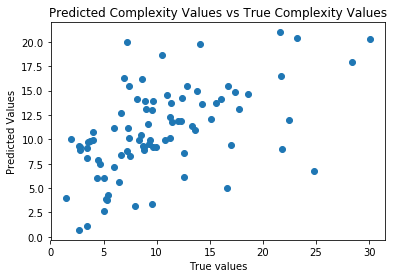

In [248]:
plt.scatter(complex_valid_y, y_pred)
plt.xlabel("True values")
plt.ylabel("Predicted Values")
plt.title("Predicted Complexity Values vs True Complexity Values")
plt.show()

Text(0.5, 1.0, 'RMSE of Lasso Regression by Lambda Values')

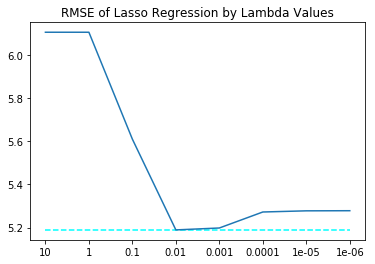

In [249]:
plt.plot(RMSE)
plt.hlines(min(RMSE), xmin=0, xmax=7, colors='aqua', linestyles='dashed')
plt.xticks(range(len(lambdas)), lambdas)
plt.title("RMSE of Lasso Regression by Lambda Values")

### How does it compare to estimating the mean? Slightly better... roughly 1 on average

In [250]:
mean_y_pred = complex_test_y.mean()
using_mean = calc_rmse(mean_y_pred, complex_test_y, complex_test.shape[0])
print("RMSE using lasso with lambda {}: ".format(best_lambda), best_rmse_lasso)
print("RMSE using mean:                   ", using_mean)

RMSE using lasso with lambda 0.01:  5.188917900540693
RMSE using mean:                    7.737871992169536


## K-means using Long and Lat

In [191]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder

In [192]:
# complex_train, complex_test, complex_train_y, complex_test_y
# complex_valid, complex_valid_y

# Takes as input: normalized train and validation data. 
# unnormalized y validation values

def compute_k_means(train, valid, valid_y, n_clusters, n_init):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=n_init)

    kmeans.fit(train)
    # kmeans.cluster_centers_

    cluster_predictions = kmeans.predict(valid)
    cluster_complexity_means = valid_y.groupby(cluster_predictions).mean()
    cluster_complexity_means

    predictions = np.zeros(len(valid))
    for i in range(len(valid)):
        if cluster_predictions[i] >= len(cluster_complexity_means):
            predictions[i] = cluster_predictions.mean()
        else:
            predictions[i] = cluster_complexity_means[cluster_predictions[i]]
            
    return predictions

# E.g.,
#   compute_k_means(complex_train, complex_valid, complex_valid_y, 10, 10)

### Run simulation to find best num_clusters

In [193]:
num_clusters = np.arange(30) + 2
RMSE = np.zeros(len(num_clusters))
count=0
best_RMSE = 10000
best_num_cluster = 0
best_predictions = None
for nc in num_clusters:
    predictions = compute_k_means(complex_train, complex_valid, complex_valid_y, nc, 10)
    RMSE[count] = calc_rmse(predictions, complex_valid_y, len(complex_valid))
    if RMSE[count] < best_RMSE:
        best_RMSE = RMSE[count]
        best_num_clusters = nc
        best_predictions = predictions
    count += 1
print("RMSE: ", RMSE)
print("best RMSE: ", best_RMSE)
print("best num clusters: ", best_num_clusters)

RMSE:  [6.12137019 6.14573321 6.72169397 6.44051462 5.84254808 6.48998671
 6.14499786 6.76062881 6.33098075 6.12454453 6.37066136 6.22368336
 6.03898596 6.71696263 5.84550517 5.68485964 5.75996123 5.84987072
 5.7627293  5.87666644 5.98974795 6.01537986 5.70488799 5.66761949
 5.70878988 6.29897311 7.10511592 6.4204275  5.9407612  6.64804828]
best RMSE:  5.667619494194024
best num clusters:  25


Text(0.5, 1.0, 'RMSE of k-means by Num Clusters')

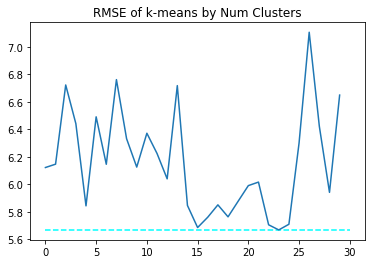

In [194]:
plt.plot(RMSE)
plt.hlines(min(RMSE), xmin=0, xmax=30, colors='aqua', linestyles='dashed')
plt.title("RMSE of k-means by Num Clusters")

### How does k-means compare to the mean?

##### What is going on

In [196]:
mean_y_pred = complex_test_y.mean()
using_mean = calc_rmse(mean_y_pred, complex_test_y, complex_test.shape[0])
print("RMSE using k-means with {} clusters: ".format(best_num_clusters), best_RMSE)
print("RMSE using mean:                     ", using_mean)

RMSE using k-means with 25 clusters:  5.667619494194024
RMSE using mean:                      8.62599052163342


## Replace missing NA values with k-mean estimations

In [251]:
complexity_NA = df[df.Complexity.isna()]

In [252]:
# Convert to nd array
if type(df_complex_means) == type(pd.Series([1,2])):
    df_complex_means = np.array(df_complex_means.values, dtype=np.float64)
if type(df_complex_stds) == type(pd.Series([1,2])):
    df_complex_stds = np.array(df_complex_stds.values, dtype=np.float64)

In [253]:
predictors = complexity_NA.columns[:-7]
predictors = predictors[1:]
complexity_NA = complexity_NA[predictors]
complexity_NA.columns

# change Island variable to numeric encoding. 
lb = LabelEncoder()
island_dummy = lb.fit_transform(complexity_NA.Island)
complexity_NA.Island = island_dummy 

In [254]:
# Normalize with scale function
normalized_preds_scale = scale(complexity_NA.values)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [255]:
# Normalize with means and stds from other data:
temp = np.array(complexity_NA.values, dtype=np.float64)
normalized_preds = (temp - df_complex_means.reshape(1,-1)) / df_complex_stds.reshape(1,-1)

print("Should be close to 0:\n", np.mean(normalized_preds, axis=0))
print("Should be close to 1:\n", np.std(normalized_preds, axis=0))

Should be close to 0:
 [ 0.04412891 -0.02347235 -0.1652385  -0.08785319 -0.03538951  0.08353132
  0.10870109 -0.06104132  0.67517521  0.46764583  0.5022411   0.97039203
  0.29536862 -0.31976062  0.14949922 -0.18646155 -0.23723812 -0.10585823
 -0.43493883 -0.40423653 -0.47463247 -0.4092645  -0.62307988 -0.3047131
  0.12022186 -0.23751238 -0.00948876  0.08104052  0.01507136 -0.04493635
  0.68129516]
Should be close to 1:
 [1.19051684 0.86204    0.74679277 1.03103217 0.99858995 1.09216093
 1.09934712 0.97959487 1.9510874  1.28228258 2.75367999 3.11729437
 1.24727376 0.52974212 0.81837784 0.92578621 0.54407116 0.91998009
 0.18446463 0.39690134 0.66950149 0.58109344 0.81516643 0.94003582
 1.21553292 0.5799352  0.87796876 0.83784709 0.99899243 0.91265203
 1.10210157]


### use the lasso regression to estimate the missing values

In [256]:
missing_complexity_predictions = lasso_model.predict(normalized_preds_scale)
missing_complexity_predictions

array([288.44306214, 289.86834613, 290.33946909, 288.33063698,
       290.95326971, 290.91107492, 273.61449753, 281.16293277,
       289.92700236, 289.96603701, 277.0314981 , 287.38023282,
       279.13833692, 279.30353765, 286.54777767, 286.80667653,
       282.92242585, 286.58226133, 286.56279656, 286.71359138,
       283.7678093 , 283.97836711, 286.37303137, 283.96372095,
       276.42104125, 284.14817884, 284.07853457, 282.74501755,
       281.95031764, 292.50316729, 292.7780463 , 295.1925141 ,
       293.36711741, 294.10537832, 295.31927198, 294.44986639,
       294.94869983, 295.70513602, 294.42850662, 294.93047533,
       281.35001641, 299.61005346, 299.30708821, 299.56519219,
       299.36792035, 292.51686462, 286.51987078, 293.739259  ,
       297.34118901, 297.35275615, 291.63222958, 299.92246368,
       267.11349066, 270.43995508, 286.10795853, 269.0200401 ,
       269.30747916, 285.30557584, 288.71758059, 274.73206322,
       287.03510823, 287.70345499, 288.85902414, 269.91

In [213]:
df.loc[df.Complexity.isna(), 'Complexity'] = missing_complexity_predictions

ValueError: Must have equal len keys and value when setting with an iterable

### Check

In [203]:
# Check if they are filled in? 
na_cols = df.apply(lambda x : x.isna().sum())
na_cols[na_cols>0].count()

0

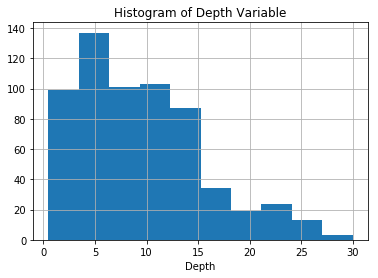

In [204]:
plt.hist(df.Depth[df.Depth.notna()])
plt.title("Histogram of Depth Variable")
plt.xlabel("Depth")
plt.grid()

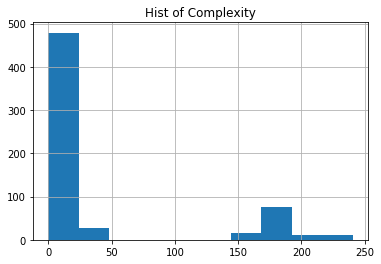

In [205]:
plt.hist(df.Complexity[df.Complexity.notna()])
plt.title("Hist of Complexity")
plt.grid()
plt.show()